Installing necessary libraries

In [ ]:
pip install torchvision keras imgaug opencv-python

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import random
import os

In [ ]:
# code to connect google drive with colab

from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
class KneeDataset(Dataset):
    def __init__(self, data_path, categories, img_size=224):
        self.data_path = data_path
        self.categories = categories
        self.img_size = img_size
        self.data = []
        self.labels = []
        self.label_dict = {category: i for i, category in enumerate(categories)}
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),  # Zoom augmentation
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self._load_data()

    def _load_data(self):
        for category in self.categories:
            folder_path = os.path.join(self.data_path, category)
            img_names = os.listdir(folder_path)
            for img_name in img_names:
                img_path = os.path.join(folder_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img)
                self.data.append(img)
                self.labels.append(self.label_dict[category])

        self.data = torch.stack(self.data)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
data_path = '/content/drive/MyDrive/knee-arthritis/Training_augmented'
categories = ['1Doubtful', '4Severe', '2Mild', '0Normal', '3Moderate']
img_size = 224

dataset = KneeDataset(data_path, categories, img_size)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

EDA for Original Dataset

In [ ]:
# Assuming the dataset is in a directory structure suitable for torchvision's ImageFolder
data_dir = '/content/drive/MyDrive/knee-arthritis/Training'
# Data transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Display sample images
def show_images(images, labels, class_names):
    plt.figure(figsize=(12, 6))
    grid = make_grid(images, nrow=5)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()

# Get a batch of images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)
images, labels = next(iter(data_loader))

# Show sample images
show_images(images, labels, dataset.classes)

# Class distribution
import seaborn as sns
import pandas as pd

labels_count = [0] * len(dataset.classes)
for _, label in dataset.samples:
    labels_count[label] += 1

df = pd.DataFrame({
    'Class': dataset.classes,
    'Count': labels_count
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=df)
plt.title('Class Distribution')
plt.show()


EDA after Augmenting Dataset

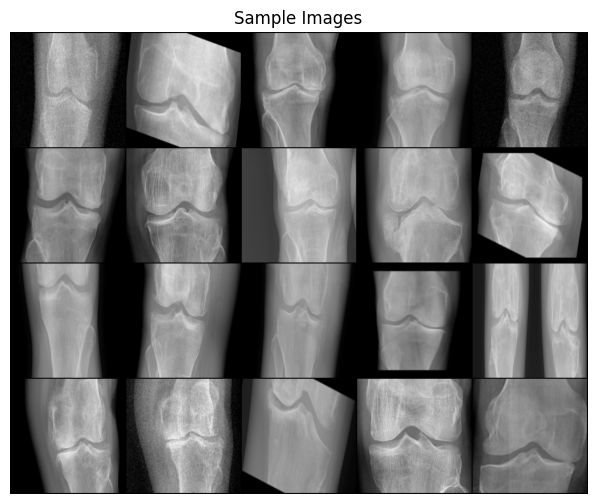

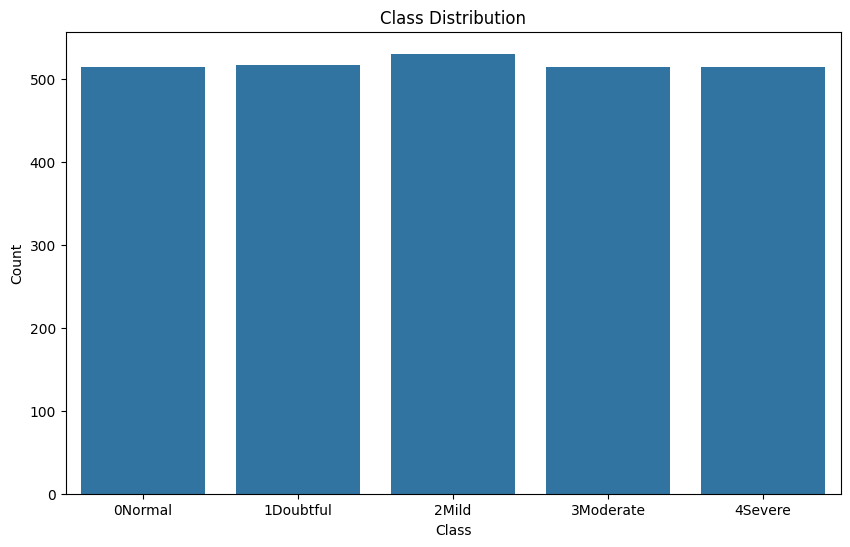

In [ ]:
# Assuming the dataset is in a directory structure suitable for torchvision's ImageFolder
data_dir = '/content/drive/MyDrive/knee-arthritis/Training_augmented'

# Data transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Display sample images
def show_images(images, labels, class_names):
    plt.figure(figsize=(12, 6))
    grid = make_grid(images, nrow=5)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()

# Get a batch of images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)
images, labels = next(iter(data_loader))

# Show sample images
show_images(images, labels, dataset.classes)

# Class distribution
import seaborn as sns
import pandas as pd

labels_count = [0] * len(dataset.classes)
for _, label in dataset.samples:
    labels_count[label] += 1

df = pd.DataFrame({
    'Class': dataset.classes,
    'Count': labels_count
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=df)
plt.title('Class Distribution')
plt.show()


Loading the ResNet-50 model

In [ ]:
# Load the ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final layer to match the number of classes
num_classes = len(categories)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Send the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


Running our Model for 100 epochs

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

num_epochs = 100
best_accuracy = 0

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Save the epoch loss

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    train_accuracies.append(accuracy)  # Save the epoch accuracy

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Best Accuracy: {best_accuracy:.4f}')

    scheduler.step()


Epoch 1/100, Loss: 1.2964, Accuracy: 0.6486, Best Accuracy: 0.6486
Epoch 2/100, Loss: 0.9637, Accuracy: 0.5753, Best Accuracy: 0.6486
Epoch 3/100, Loss: 0.7010, Accuracy: 0.6641, Best Accuracy: 0.6641
Epoch 4/100, Loss: 0.5577, Accuracy: 0.5019, Best Accuracy: 0.6641
Epoch 5/100, Loss: 0.3460, Accuracy: 0.6873, Best Accuracy: 0.6873
Epoch 6/100, Loss: 0.2444, Accuracy: 0.6873, Best Accuracy: 0.6873
Epoch 7/100, Loss: 0.1688, Accuracy: 0.6139, Best Accuracy: 0.6873
Epoch 8/100, Loss: 0.2297, Accuracy: 0.7181, Best Accuracy: 0.7181
Epoch 9/100, Loss: 0.1297, Accuracy: 0.7143, Best Accuracy: 0.7181
Epoch 10/100, Loss: 0.1470, Accuracy: 0.7027, Best Accuracy: 0.7181
Epoch 11/100, Loss: 0.1034, Accuracy: 0.7722, Best Accuracy: 0.7722
Epoch 12/100, Loss: 0.1115, Accuracy: 0.6795, Best Accuracy: 0.7722
Epoch 13/100, Loss: 0.1507, Accuracy: 0.6757, Best Accuracy: 0.7722
Epoch 14/100, Loss: 0.1158, Accuracy: 0.6873, Best Accuracy: 0.7722
Epoch 15/100, Loss: 0.0654, Accuracy: 0.7452, Best Accura

Plotting Accuracy and Loss

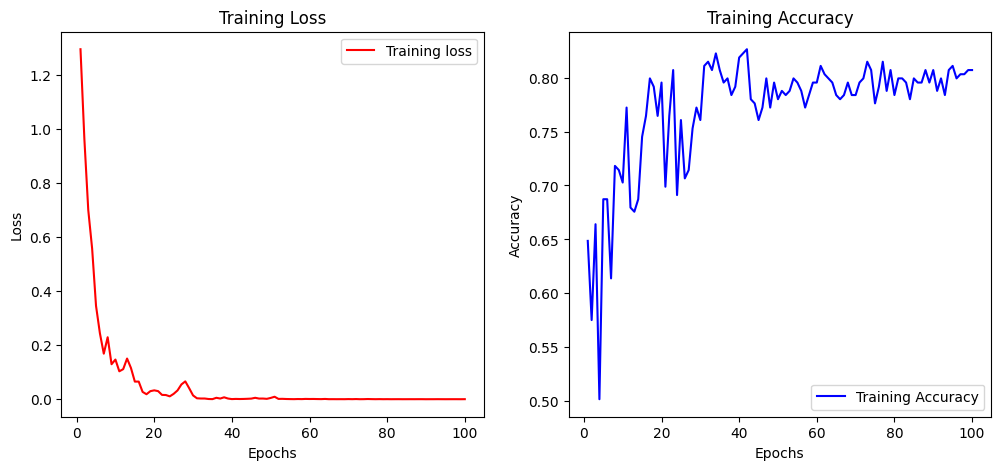

In [ ]:
# Assuming 'train_losses' and 'train_accuracies' are lists storing loss and accuracy for each epoch

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


Testing the model in real-time

In [ ]:
# Define the path to the training folder and the transformation
training_folder = '/content/drive/MyDrive/knee-arthritis/Training_augmented'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Get a list of all image files in the training folder
all_images = []
for label in os.listdir(training_folder):
    label_folder = os.path.join(training_folder, label)
    if os.path.isdir(label_folder):
        for img_file in os.listdir(label_folder):
            if img_file.endswith('.png'):
                all_images.append((label, os.path.join(label_folder, img_file)))

# Pick a random image
random_label, random_image_path = random.choice(all_images)

# Load the image and apply transformations
image = Image.open(random_image_path).convert('RGB')
image = transform(image).unsqueeze(0).to(device)

# Get the model prediction
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Check if the prediction is correct
predicted_label = predicted.item()
is_correct = predicted_label == int(random_label[0])

print(f"Random Image Path: {random_image_path}")
print(f"True Label: {random_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Correct: {is_correct}")


Random Image Path: /content/drive/MyDrive/knee-arthritis/Training_augmented/4Severe/SevereG4 (172)_aug_131.png
True Label: 4Severe
Predicted Label: 4
Prediction Correct: True


Accuracy: 80.69%


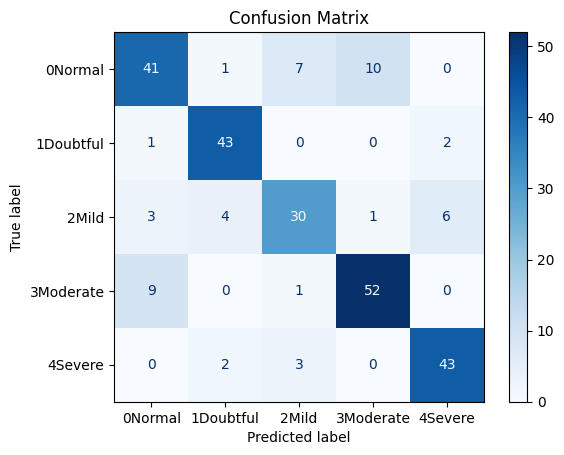

In [ ]:
# Final prediction code
def predict_and_display(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Plotting confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Assuming 'test_loader' is the DataLoader for the test dataset
predict_and_display(model, test_loader, device)


Test research

In [ ]:
# Best accuracy was 80.61 when using lr=1e-2, step size = 30 and no. of epochs = 25
# Best accuracy was 78.18 when using lr=1e-3, step size = 25 and no. of epochs = 25
# Best accuracy was 81.21 when using lr=1e-2, step size = 50 and no. of epochs = 20
# Best accuracy was 80.61 when using lr=1e-2, step size = 75 and no. of epochs = 20